In [2]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
#import sys
#sys.path.append('/Users/rociokiman/Documents/Gaia-Cupid/ActivityAgeRelation/banyan_sigma')
#from banyan_sigma import banyan_sigma
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord  
import astropy.units as u
import os
#import random
%matplotlib notebook

In [4]:
literature_search = Table.read('Catalogs/literature_search_gaia.fits')
order = 2
'''
Select the catalogs which are first and second order compatible with
Kiman et al. 2019. from the literature search sample.
'''
source_ref_table = Table.read('data/source_ref.csv')
#Numbers for each reference
source_num_ref = source_ref_table['source_num']

ra = np.array(literature_search['ra'])
dec = np.array(literature_search['dec'])
ewha = np.array(literature_search['ewha'])
ewha_err = np.array(literature_search['ewha_error'])
source_num = np.array(literature_search['source_num'])

#Identify repeated stars
same_star = find_repeated_stars(ra,dec)
literature_search['same_star'] = same_star

Finding repeated stars:
0 out of 86918
10000 out of 86918
20000 out of 86918
30000 out of 86918
40000 out of 86918
50000 out of 86918
60000 out of 86918
70000 out of 86918
80000 out of 86918


In [31]:
#Identify repeated measurements
mask_idx_to_remove = remove_repeated_measurements(ewha,ewha_err,same_star)

#Using the repeated stars identify compatible catalogs
mask_kiman = source_ref_table['source_ref'] == 'Kiman 2019'
idx_kiman = source_ref_table['source_num'][mask_kiman][0]

res = find_compatible_catalogs(idx_kiman,source_num_ref,same_star,source_num,
                               ewha,max_order=2)
compatible,prob,total_comp,order = res

In [32]:
print('Compatible catalogs: {}'.format(compatible))
#Using the list of compatible catalogs make a mask of compatible stars
#and define the final sample of compatible stars.
mask_compatible = np.array([x in compatible for x 
                            in source_num[~mask_idx_to_remove]])

#Remove repeated measurements
ls_compatible = literature_search[~mask_idx_to_remove]
print('Unrepeated measurements of ha: {}'.format(len(ls_compatible)))

#Add a new ewha column to distinguish between compatible and not compatible
ls_compatible['ewha_all'] = ls_compatible['ewha']
ls_compatible['ewha_error_all'] = ls_compatible['ewha_error']
ls_compatible['ewha'][~mask_compatible] = np.nan
ls_compatible['ewha_error'][~mask_compatible] = np.nan

Compatible catalogs: [ 0  1  4  5  6  7  8 11 14 15 17 18 19 20 23 24 25 27 28 30 31 34 36 37
 38 40 41 42 43 44 45 46 48 49 50 51 52 54 56 57]
Unrepeated measurements of ha: 86085


In [34]:
Ncomp = len(ls_compatible['ewha'][~np.isnan(ls_compatible['ewha'])])
make_table_for_paper_sources(ls_compatible['source_num'],Ncomp,
                             compatible,total_comp,order)

0

In [33]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
from astropy.table import Table
#import numpy as np

def make_table_for_paper_sources(source_num,Ncomp,compatible,total_comp,order):
     
    dropbox_path = '/Users/rociokiman/Dropbox/Apps/Overleaf/'
    paper = 'Age-Activity Relation for M dwarfs/'
    os.remove(dropbox_path + paper + 'sources_summary.tex')
    file_sources = open(dropbox_path + paper + 'sources_summary.tex','x')
    
    source_ref_table = Table.read('data/source_ref.csv')
    
    #Ntot = len(ra)
    #Ncomp = len(ls_compatible[~np.isnan(ls_compatible['ewha'])])
    n_sources = len(source_ref_table['source_ref'])
    total_incompatible = 0
    papers_notes = 'Other works checked in literature search but were considered incompatible: '
    #Header
    file_sources.write('\\begin{deluxetable*}{ccccc}[ht!]\n')
    file_sources.write('\\tablewidth{290pt}\n')
    file_sources.write('\\tabletypesize{\scriptsize}\n')
    file_sources.write('\\tablecaption{Compatible references for $\haew$. \\label{table:source_ref}}\n')
    file_sources.write('\\tablehead{\\colhead{Reference \\tablenotemark{a}} & \\colhead{Resolution} & \\colhead{$N$ Stars} & \\colhead{$N$ Stars Compatible} & \\colhead{OC \\tablenotemark{b}} \\\ & & Total='+str(Ncomp) +'& &\n}')
    file_sources.write('\\startdata \n')
    
    for i in range(n_sources):
        if i in compatible:
            mask = i == compatible
            compatible_i = int(total_comp[mask][0])
            order_i = int(order[mask][0])
        else:
            compatible_i = 0
            order_i = '-'
        n_i = len(source_num[source_num == i])
        if(n_i!=0 and compatible_i!=0):
            file_sources.write('{}&{}&{}&{}&{}\\\ \n'.format(source_ref_table['cite'][i],source_ref_table['resolution'][i],
                                                   n_i,compatible_i,order_i)) 
        elif(compatible_i==0):
            total_incompatible += n_i
            papers_notes = papers_notes + source_ref_table['cite'][i] + ', '
    file_sources.write('\\enddata \n')
    file_sources.write('\\tablenotetext{a}{'+ papers_notes +'.}\n')
    file_sources.write('\\tablenotetext{b}{Order of compatibility. Order 1 is compatible with \\citet{Kiman2019}. Order 2 are compatible with order 1 catalogs.}\n')
    file_sources.write('\\end{deluxetable*}\n')

    return 0



In [30]:
from scipy.io.idl import readsav
path = 'Catalogs/rocio_praesepe_sample.sav'
#extracting best young asociationg and probability of being member
results = readsav(path,verbose=1)

IDL Save file is compressed
 -> expanding to /var/folders/8z/_8g9xgs96yd186lrg1z24zq80000gn/T/tmpe25f77zy.sav
--------------------------------------------------
Date: Tue Apr  7 16:46:26 2020
User: gagne
Host: Alcyone.local
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: darwin
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 5 records of which:
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
 - 2 are of type VARIABLE
--------------------------------------------------
Available variables:
 - input [<class 'numpy.recarray'>]
 - out [<class 'numpy.recarray'>]
--------------------------------------------------


In [2]:
literature_search1 = Table.read('Catalogs/literature_search_gaia.fits')
source_ref_table = Table.read('data/source_ref.csv')

In [3]:
idx_kiman = source_ref_table['source_num'][source_ref_table['source_ref'] == 'Kiman 2019'][0]

In [4]:
#Numbers for each reference
source_num_ref = source_ref_table['source_num']

In [5]:
#Remove haew nans and zeros from the sample. We don't want them!
mask_nan = (~np.isnan(np.array(literature_search1['ewha']))) * (np.array(literature_search1['ewha'])!=0)
literature_search2 = literature_search1[mask_nan]

In [6]:
ra2 = np.array(literature_search2['ra'])
dec2 = np.array(literature_search2['dec'])
ewha2 = np.array(literature_search2['ewha'])
ewha_err2 = np.array(literature_search2['ewha_error'])
source2 = np.array(literature_search2['source_ref'])
source_num2 = np.array(literature_search2['source_num'])
source_ref2 = np.array(literature_search2['source_ref'])

In [48]:
#Finds repeated stars and assigns them the same number in the array same_star. 
#The number starts at 1. Stars with same_star = 0 are singles.
#The stars are consider the same if the are closer than 2arcsec.
Ntot = len(ra2)
same_star2 = np.zeros(Ntot)
c_all = SkyCoord(ra=ra2*u.deg, dec=dec2*u.deg)
dummy = 1
for i in range(Ntot):
    if(i%10000==0):
        print('{} out of {}'.format(i,Ntot))
    if(same_star2[i]==0):
        c1 = SkyCoord(ra=ra2[i]*u.deg, dec=dec2[i]*u.deg)
        separation = c1.separation(c_all).arcsec
        mask_close = separation < 2
        if(len(ra2[mask_close])>1):
            same_star2[mask_close] = dummy
            dummy+=1

0 out of 84566
10000 out of 84566
20000 out of 84566
30000 out of 84566
40000 out of 84566


KeyboardInterrupt: 

In [9]:
literature_search2['same_star'] = same_star2

In [31]:
#remove repeated stars
N_ref = len(source_num_ref)

idx = np.arange(len(ewha2))
idx_to_remove = []
for x in range(1,int(max(same_star2)+1)):
    #Select group of the same star with the mask
    mask = (same_star2 == x) 
    if(len(ewha2[mask])>1):
        #Select the ewha of the repeated star
        ewha_mask = np.round(ewha2[mask],3)
        ewha_err_mask = ewha_err2[mask]
        idx_mask = idx[mask]
        if(len(ewha_mask) != len(set(ewha_mask))):
            seen = []
            for x in ewha_mask:
                mask_zero = ewha_mask-x == 0
                if(len(ewha_mask[mask_zero])>1 and x not in seen):
                    idx_mask_zero = idx_mask[mask_zero]
                    mask_not_nan = ~np.isnan(ewha_err_mask[mask_zero])
                    if(len(idx_mask_zero[mask_not_nan])!=0):
                        idx_to_keep = idx_mask_zero[mask_not_nan][0]
                    else:
                        idx_to_keep = idx_mask_zero[0]
                    seen.append(x)
                    for y in idx_mask_zero[idx_mask_zero!=idx_to_keep]:
                        idx_to_remove.append(y)

In [32]:
idx_to_remove = np.array(idx_to_remove)

In [33]:
mask_idx_to_remove = np.array([True if x in idx_to_remove else False for x in idx])

In [34]:
literature_search = literature_search2[~mask_idx_to_remove]

In [35]:
len(literature_search)

83766

In [36]:
ra = np.array(literature_search['ra'])
dec = np.array(literature_search['dec'])
ewha = np.array(literature_search['ewha'])
ewha_err = np.array(literature_search['ewha_error'])
source = np.array(literature_search['source_ref'])
source_num = np.array(literature_search['source_num'])
source_ref = np.array(literature_search['source_ref'])
same_star = np.array(literature_search['same_star'])

In [37]:
N_ref = len(source_num_ref)
ewha_i = []
ewha_j = []
#Set up a matrix that will count the catalogs that can be considered compatible
#accorgin to halpha
matrix_prob = np.ones((N_ref,N_ref))*0
#Set up a matrix that will count how many stars the catalogs have in common
matrix_prob_all = np.ones((N_ref,N_ref))*0

for x in range(1,int(max(same_star)+1)):
    #Select group of the same star with the mask
    mask = (same_star == x) *~np.isnan(ewha)
    if(len(ewha[mask])>1):
        ### --- Test for the selection of equal stars --- ### 
        #if(19 in source_num[mask]):
        #    print(x)
        #    for ra_i,dec_i,source_i in zip(ra[mask],dec[mask],source[mask]):
        #        print(ra_i,dec_i,source_i)
        ### --- --- ###
        
        #Select the sources where the star is repeated
        source_num_mask = source_num[mask]
        #Select the ewha of the repeated star
        ewha_mask = ewha[mask]
        
        N = len(source_num_mask)
        for i in range(N):
            for j in range(N):
                if(source_num_mask[i]!=source_num_mask[j]):
                    #If the differene of the ewha is smaller than 3A,
                    #then add a 1 to matrix_prob
                    if(abs(ewha_mask[i]-ewha_mask[j])<3):
                        matrix_prob[int(source_num_mask[i]),int(source_num_mask[j])]+=1
                    matrix_prob_all[int(source_num_mask[i]),int(source_num_mask[j])]+=1
                if(source_num_mask[i]<source_num_mask[j]):
                    ewha_i.append(ewha_mask[i])
                    ewha_j.append(ewha_mask[j])
                        
#mean,std,delta = np.array(mean),np.array(std),np.array(delta)
ewha_i, ewha_j = np.array(ewha_i), np.array(ewha_j)

(-3, 20)

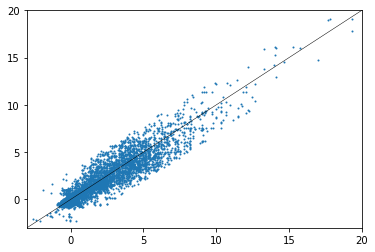

In [38]:
x = np.linspace(-3,20)
mask_ha = abs(ewha_i-ewha_j)<3
plt.scatter(ewha_i[mask_ha],ewha_j[mask_ha],s=1)
plt.plot(x,x,'k-',linewidth=.5)
plt.xlim(-3,20)
plt.ylim(-3,20)

In [39]:
compatible = []
prob = []
total_comp = []
order = []
#First order compatible catalogs
for i in range(N_ref):
    if(matrix_prob[i,idx_kiman] > 0.0):
        prob_i = matrix_prob[i,idx_kiman]/matrix_prob_all[i,idx_kiman]
        if(i not in compatible and prob_i > 0.9):
            compatible.append(i)
            prob.append(prob_i)
            total_comp.append(matrix_prob[i,idx_kiman])
            order.append(1)

print(compatible)
#Second order compatible catalogs
for i in compatible:
    for j in range(N_ref):
        if((matrix_prob[j,i] > 0)):
            prob_j = matrix_prob[j,i]/matrix_prob_all[j,i]
            if(j not in compatible and prob_j > 0.9):
                compatible.append(j)
                prob.append(prob_j)
                total_comp.append(matrix_prob[j,i])
                order.append(2)
compatible,prob,total_comp,order = np.array(compatible),np.array(prob),np.array(total_comp),np.array(order)
idx = np.argsort(compatible)
compatible = compatible[idx]
prob = prob[idx]
total_comp = total_comp[idx]
order = order[idx]

for x,y,z,w in zip(compatible,prob,total_comp,order):
    print(source_ref_table['source_ref'][x],y,z,w)
    
#compatible = list(compatible)
#compatible.remove(source_num_ref[source_ref_table['source_ref']=='Reiners 2010'][0])
#compatible.append(source_num_ref[source_ref_table['source_ref']=='Newton 2017'][0])
#compatible.append(source_num_ref[source_ref_table['source_ref']=='Gizis 2002'][0])
#compatible.append(source_num_ref[source_ref_table['source_ref']=='Alonso-Floriano 2015'][0])
#compatible = np.sort(compatible)
#compatible = np.array(compatible)

[6, 8, 37, 41, 57]
Alonso-Floriano 2015 1.0 5.0 2
Ansdell 2015 1.0 4.0 2
Bouy 2009 1.0 1.0 2
Douglas 2014 1.0 60.0 1
Elliott 2016 1.0 1.0 2
Fang 2018 1.0 1.0 1
Gaidos 2014 1.0 1.0 2
Gizis 2002 0.96 24.0 2
Hawley 1996 1.0 1.0 2
Jayawardhana 2006 1.0 2.0 2
Jeffers 2018 1.0 7.0 2
Kiman 2019 1.0 60.0 2
Kraus 2014 1.0 9.0 2
Lepine 2013 1.0 4.0 2
LG11 0.9375 15.0 2
Lyo 2004 1.0 2.0 2
Malo 2014 0.9230769230769231 12.0 2
Mochnacki 2002 1.0 8.0 2
Mohanty 2003 1.0 1.0 2
Newton 2017 0.9375 15.0 2
Reid 1995 1.0 3.0 2
Reid 2002 1.0 2.0 1
Reid 2007 1.0 1.0 2
Reiners 2008 1.0 1.0 2
Reiners 2010 1.0 2.0 1
Riaz 2006 0.9230769230769231 12.0 2
Riedel 2014 1.0 1.0 2
Rodriguez 2014 0.9375 15.0 2
Schneider 2019 0.9655172413793104 28.0 2
Shkolnik 2009 0.918918918918919 34.0 2
Shkolnik 2017 1.0 4.0 2
Song 2003 1.0 1.0 2
Song 2004 1.0 2.0 2
Terrien 2015 1.0 6.0 2
Torres 2006 0.9333333333333333 14.0 2
West 2011 1.0 10.0 1


In [40]:
mask_compatible = np.array([x in compatible for x in source_num])

In [41]:
len(literature_search[mask_compatible])

83100

In [42]:
not_compatible = []
for n in range(N_ref):
    if(n not in compatible):
        not_compatible.append(n)

In [43]:
N_ref = len(source_num_ref)
mean_compatible,std_compatible,delta_compatible=[],[],[]
for x in range(1,int(max(same_star)+1)):
    mask = (same_star == x) * mask_compatible
    if(len(ewha[mask])>1):
        mean_compatible.append(np.nanmean(ewha[mask]))
        std_compatible.append(np.nanstd(ewha[mask]))
        delta_compatible.append(np.nanmax(ewha[mask])-np.nanmin(ewha[mask]))
                        
mean_compatible = np.array(mean_compatible)
std_compatible,delta_compatible = np.array(std_compatible),np.array(delta_compatible)

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


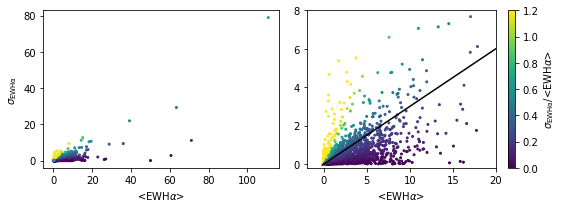

In [44]:
x = np.linspace(-0.2,140)
y = x*0.3
f,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3)) 
cax = ax1.scatter(abs(mean_compatible),std_compatible,c=abs(std_compatible/mean_compatible),s=4,vmin=0,vmax=1.2)
ax1.set_xlabel(r'<EWH$\alpha$>')
ax1.set_ylabel(r'$\sigma_{\rm EWH\alpha}$')

ax2.scatter(abs(mean_compatible),std_compatible,c=abs(std_compatible/mean_compatible),s=4,vmin=0,vmax=1.2)
ax2.plot(x,y,'k-')
ax2.set_xlim(-2,20)
ax2.set_ylim(-0.2,8)
ax2.set_xlabel(r'<EWH$\alpha$>')

plt.colorbar(cax,label=r'$\sigma_{\rm EWH\alpha}$/<EWH$\alpha$>')
plt.tight_layout()
plt.show()

In [45]:
literature_search['ewha_all'] = literature_search['ewha']
literature_search['ewha_error_all'] = literature_search['ewha_error']
literature_search['ewha'][~mask_compatible] = np.nan
literature_search['ewha_error'][~mask_compatible] = np.nan

In [17]:
literature_search['same_star'] = same_star

In [18]:
literature_search.sort(['source_ref', 'ra', 'dec'])

In [19]:
len(literature_search[~np.isnan(literature_search['ewha'])])

83985

(array([1.0000e+00, 1.7000e+01, 2.9000e+01, 1.2600e+02, 1.2000e+02,
        2.2400e+02, 4.5910e+03, 1.4785e+04, 2.0240e+04, 1.5888e+04,
        1.1515e+04, 8.8870e+03, 3.8400e+03, 9.2700e+02, 2.5300e+02,
        8.7000e+01, 1.6000e+01, 8.0000e+00, 3.0000e+00]),
 array([0.        , 0.13157895, 0.26315789, 0.39473684, 0.52631579,
        0.65789474, 0.78947368, 0.92105263, 1.05263158, 1.18421053,
        1.31578947, 1.44736842, 1.57894737, 1.71052632, 1.84210526,
        1.97368421, 2.10526316, 2.23684211, 2.36842105, 2.5       ]),
 <a list of 19 Patch objects>)

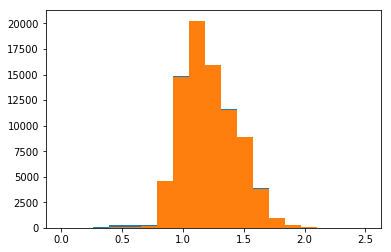

In [23]:
color = literature_search['phot_g_mean_mag'] - literature_search['phot_rp_mean_mag']
x = np.linspace(0,2.5,20)
plt.hist(color,bins=x)
plt.hist(color[mask_compatible],bins=x)

In [32]:
literature_search

ra,dec,spt,ewha,ewha_error,lhalbol,lhalbol_error,age,age_error,group_num,group_name,source_num,source_ref,ewha_all,ewha_error_all,same_star
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes32,float64,bytes20,float64,float64,float64
1.9275999999999998,60.381787499999994,nan,5.638999938964844,0.4000000059604645,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,5.638999938964844,0.4000000059604645,1.0
2.8825499999999997,59.14442777777777,nan,0.9769999980926514,0.4000000059604645,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,0.9769999980926514,0.4000000059604645,2.0
2.9710166666666664,22.984545833333332,nan,-0.02800000086426735,0.20000000298023224,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,-0.02800000086426735,0.20000000298023224,3.0
2.9851666666666663,33.05468,nan,-0.210999995470047,0.20000000298023224,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,-0.210999995470047,0.20000000298023224,4.0
4.0608958333333325,19.86043611111111,nan,3.628000020980835,0.4000000059604645,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,3.628000020980835,0.4000000059604645,5.0
7.839783333333332,0.1581936111111111,nan,-0.11999999731779099,0.10000000149011612,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,-0.11999999731779099,0.10000000149011612,0.0
11.624799999999999,50.64408333333333,nan,-0.02800000086426735,0.20000000298023224,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,-0.02800000086426735,0.20000000298023224,6.0
11.680691666666664,-4.412718055555555,nan,0.2460000067949295,0.30000001192092896,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,0.2460000067949295,0.30000001192092896,0.0
12.123845833333332,75.31335416666666,nan,0.5199999809265137,0.30000001192092896,nan,nan,nan,nan,nan,nan,0.0,Alonso-Floriano 2015,0.5199999809265137,0.30000001192092896,7.0


In [24]:
literature_search.write('Catalogs/literature_search_compatible.fits',format='fits',overwrite=True)

In [215]:
os.remove('/Users/rociokiman/Dropbox/Apps/Overleaf/Age-Activity Relation for M dwarfs/sources_summary.tex')
file_sources = open('/Users/rociokiman/Dropbox/Apps/Overleaf/Age-Activity Relation for M dwarfs/sources_summary.tex','x')

In [216]:
Ntot = len(ra)
Ncomp = len(ra[mask_compatible])
n_sources = len(source_ref_table['source_ref'])
total_incompatible = 0
papers_notes = 'Other works checked in literature search but were considered incompatible: '
#Header
file_sources.write('\\begin{deluxetable*}{ccccc}[ht!]\n')
file_sources.write('\\tablewidth{290pt}\n')
file_sources.write('\\tabletypesize{\scriptsize}\n')
file_sources.write('\\tablecaption{Compatible references for $\haew$. \\label{table:source_ref}}\n')
file_sources.write('\\tablehead{\\colhead{Reference \\tablenotemark{a}} & \\colhead{Resolution} & \\colhead{$N$ Stars} & \\colhead{$N$ Stars Compatible} & \\colhead{OC \\tablenotemark{b}} \\\ & & Total='+str(Ncomp) +'& &\n}')
file_sources.write('\\startdata \n')

for i in range(n_sources):
    if i in compatible:
        mask = i == compatible
        compatible_i = int(total_comp[mask][0])
        order_i = int(order[mask][0])
    else:
        compatible_i = 0
        order_i = '-'
    n_i = len(ra[source_num == i])
    if(n_i!=0 and compatible_i!=0):
        file_sources.write('{}&{}&{}&{}&{}\\\ \n'.format(source_ref_table['cite'][i],source_ref_table['resolution'][i],
                                               n_i,compatible_i,order_i)) 
    elif(compatible_i==0):
        total_incompatible += n_i
        papers_notes = papers_notes + source_ref_table['cite'][i] + ', '
file_sources.write('\\enddata \n')
file_sources.write('\\tablenotetext{a}{'+ papers_notes +'.}\n')
file_sources.write('\\tablenotetext{b}{Order of compatibility. Order 1 is compatible with \\citet{Kiman2019}. Order 2 are compatible with order 1 catalogs.}\n')
file_sources.write('\\end{deluxetable*}\n')

19

In [217]:
file_sources.close()

In [12]:
'''#Define a new table to sort by ra and dec
literature_search_sorted = literature_search
#Define number id that helps identify each star
literature_search_sorted['extra_id'] = np.arange(len(literature_search['ra']))
#Sort new table
literature_search_sorted.sort(('ra','dec'))
#index to sent arrays to original state
idx = np.argsort(literature_search_sorted['extra_id'])
#New arrays ra,dec sorted
ra_sorted = literature_search_sorted['ra']
dec_sorted = literature_search_sorted['dec']

#Defines an array that is going to indicate which stars are the same. 
#Having the same number in same_star_sorted means they are the same star.
same_star_sorted = np.zeros(len(ra_sorted))
dummy = 1
for i in range(len(ra_sorted)-1):
    c1 = SkyCoord(ra=ra_sorted[i]*u.deg, dec=dec_sorted[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted[i+1]*u.deg, dec=dec_sorted[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation <= 5):
        same_star_sorted[i] = dummy
        same_star_sorted[i+1] = dummy
    else:
        dummy +=1

same_star = same_star_sorted[idx]
'''


"#Define a new table to sort by ra and dec\nliterature_search_sorted = literature_search\n#Define number id that helps identify each star\nliterature_search_sorted['extra_id'] = np.arange(len(literature_search['ra']))\n#Sort new table\nliterature_search_sorted.sort(('ra','dec'))\n#index to sent arrays to original state\nidx = np.argsort(literature_search_sorted['extra_id'])\n#New arrays ra,dec sorted\nra_sorted = literature_search_sorted['ra']\ndec_sorted = literature_search_sorted['dec']\n\n#Defines an array that is going to indicate which stars are the same. \n#Having the same number in same_star_sorted means they are the same star.\nsame_star_sorted = np.zeros(len(ra_sorted))\ndummy = 1\nfor i in range(len(ra_sorted)-1):\n    c1 = SkyCoord(ra=ra_sorted[i]*u.deg, dec=dec_sorted[i]*u.deg)\n    c2 = SkyCoord(ra=ra_sorted[i+1]*u.deg, dec=dec_sorted[i+1]*u.deg)\n    separation = c1.separation(c2).arcsec\n    if(separation <= 5):\n        same_star_sorted[i] = dummy\n        same_star_sor